In [50]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./data/MSCallGraph/MSCallGraph_0.csv")

In [3]:
df.head()

,Unnamed: 0,traceid,timestamp,rpcid,um,rpctype,dm,interface,rt
0,0,0b133c1915919238193454000e5d37,219678,0.1.3.1.1.1.12,5cca70246befb1f4c9546d2912b9419dee54439218efa5...,mc,b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...,NaN,0
1,1,0b133c1915919238193454000e5d37,219684,0.1.3.1.1.14.19,5cca70246befb1f4c9546d2912b9419dee54439218efa5...,mc,b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...,NaN,1
2,2,0b133c1915919238193454000e5d37,219684,0.1.3.1.1.14.18,5cca70246befb1f4c9546d2912b9419dee54439218efa5...,mc,b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...,NaN,1
3,3,0b133c1915919238193454000e5d37,219684,0.1.3.1.1.14.4,5cca70246befb1f4c9546d2912b9419dee54439218efa5...,mc,b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...,NaN,1
4,4,0b133c1915919238193454000e5d37,219684,0.1.3.1.1.14.17,5cca70246befb1f4c9546d2912b9419dee54439218efa5...,mc,b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...,NaN,1


In [4]:
traceids = df['traceid'].unique()

In [5]:
def tracegraph(index=0, save=False):
    tdf = df[df['traceid']==traceids[index]] # trace data frame 
    tdf = tdf.sort_values(by="rpcid", key=lambda col: col.str.split(".").str.len()) # to order from surface down
    print(f"Total calls: {len(tdf)}")
    print(f"Total unique DMs: {len(tdf['dm'].unique())}")
    class Node:
        def __init__(self, id):
            self.id = id
            self.calls = []
    nodes = {}
    for i, (idx, row) in enumerate(tdf.iterrows()):
        um = row["um"]
        dm = row["dm"]
        if um == "(?)" or str(um).lower() == "nan":
            nodes[dm] = Node(dm)
        else:
            if um not in nodes:
                nodes[um] = Node(um)
            if dm not in nodes and not (dm == "(?)" or str(dm).lower() == "nan"):
                nodes[dm] = Node(dm)
            if dm in nodes:
                nodes[um].calls.append(nodes[dm])

    print(f"Total Nodes: {len(nodes)}")
    print("Note: expect off by 1 or 2 because of nan and (?)")

    node_id_to_index = {node_id: idx for idx, node_id in enumerate(nodes.keys())}

        
    graph = nx.DiGraph() 

    for node_id, node in nodes.items():
        graph.add_node(node_id_to_index[node_id])
    for node_id, node in nodes.items():
        for call in node.calls:
            graph.add_edge(node_id_to_index[node_id], node_id_to_index[call.id])
    
    plt.figure(figsize=(13, 13))
    pos = nx.spring_layout(graph)  
    nx.draw_networkx_nodes(graph, pos, node_size=600, node_color="lightblue")
    nx.draw_networkx_edges(graph, pos, arrowstyle="->", arrowsize=20)
    nx.draw_networkx_labels(graph, pos, font_size=10, font_color="black")
    
    plt.title("Microservice Call Graph")
    if save:
        plt.savefig(f"tracegraph+{index}.png")
    plt.show()

In [6]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
interact(tracegraph, index=widgets.IntSlider(min=0, max=len(traceids)-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='index', max=130511), Checkbox(value=False, description='…

Total calls: 165
Total unique DMs: 39
Total Nodes: 39
Note: expect off by 1 or 2 because of nan and (?)
13


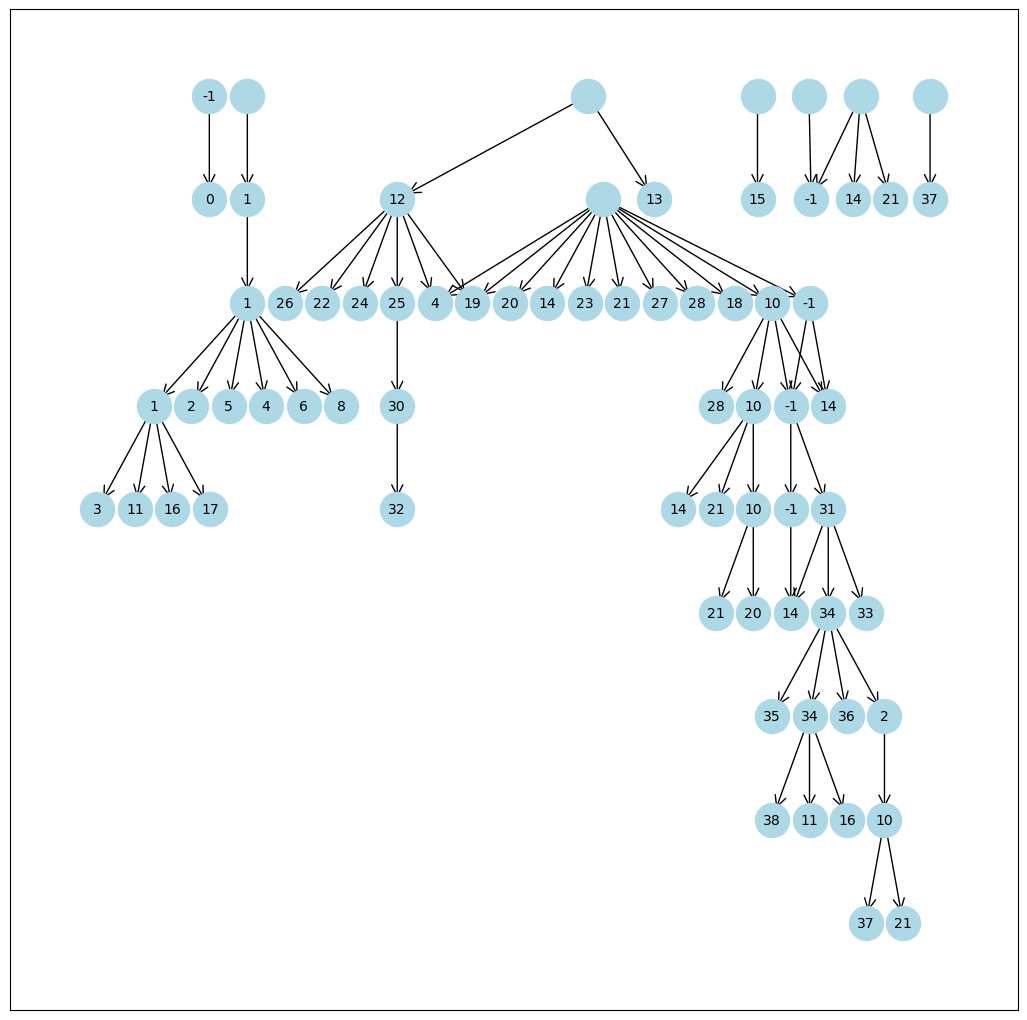

In [56]:
def tracegraph_seq(index=0, save=False):
    tdf = df[df['traceid']==traceids[index]] # trace data frame 
    tdf = tdf.sort_values(by="rpcid", key=lambda col: col.str.split(".").str.len()) # to order from surface down
    print(f"Total calls: {len(tdf)}")
    print(f"Total unique DMs: {len(tdf['dm'].unique())}")
    class Node:
        def __init__(self, id):
            self.id = id
            self.calls = []
    rpcid_calls={}
    nodes = {}
    for i, (idx, row) in enumerate(tdf.iterrows()):
        um = row["um"]
        dm = row["dm"]
        rpcid = row["rpcid"]
        rpcid_call = []
        if rpcid in rpcid_calls:
            rpcid_call = rpcid_calls[rpcid]
            if not (um == "(?)" or str(um).lower() == "nan"):
                rpcid_call[0] = um
            if not (dm == "(?)" or str(dm).lower() == "nan"):
                rpcid_call[1] = dm
        else:
            rpcid_call = [um, dm]
        rpcid_calls[rpcid] = rpcid_call
        if um == "(?)" or str(um).lower() == "nan":
            nodes[dm] = Node(dm)
        else:
            if um not in nodes:
                nodes[um] = Node(um)
            if dm not in nodes and not (dm == "(?)" or str(dm).lower() == "nan"):
                nodes[dm] = Node(dm)
            if dm in nodes:
                nodes[um].calls.append(nodes[dm])

    print(f"Total Nodes: {len(nodes)}")
    print("Note: expect off by 1 or 2 because of nan and (?)")

    node_id_to_index = {node_id: idx for idx, node_id in enumerate(nodes.keys())}
    node_id_to_index['(?)'] = -1
    node_id_to_index[np.nan] = -1

    # rpcid_calls = {k: [node_id_to_index[u], node_id_to_index[d]] for k, (u,d) in rpcid_calls.items()}
    max_len = len(max(rpcid_calls.items(), key=lambda x:len(x[0].split(".")))[0].split("."))
    print(max_len)
    tiers = [[] for _ in range(max_len+1)]
    for k,v in rpcid_calls.items():
        tiers[len(k.split("."))].append(k)

    graph = nx.DiGraph()
    start = None
    
    # Build the graph
    for i, tier in enumerate(tiers):
        for call in tier:
            um, dm = rpcid_calls[call]
            if len(graph.nodes) < 1:  # If graph is empty
                start = (um, i - 1)
                graph.add_node(start, label=str(node_id_to_index.get(um, -1)))
            graph.add_node((dm, i), label=str(node_id_to_index.get(dm, -1)))
    for i, tier in enumerate(tiers):
        for call in tier:
            um, dm = rpcid_calls[call]
            graph.add_edge((um, i - 1), (dm, i))
    
    # Check if the graph is not empty
    if start:
        plt.figure(figsize=(13, 13))
    
        # Use graphviz_layout for left-to-right layout
        pos = nx.nx_agraph.graphviz_layout(graph, prog="dot",args="-Gnodesep=10.0 -Granksep=1.5")
    
        # Draw the graph
        nx.draw_networkx_nodes(graph, pos, node_size=600, node_color="lightblue")
        nx.draw_networkx_edges(graph, pos, arrowstyle="->", arrowsize=20)
    
        # Retrieve labels
        labels = nx.get_node_attributes(graph, "label")
        nx.draw_networkx_labels(graph, pos, labels, font_size=10, font_color="black")
    
        plt.show()
    else:
        print("Graph is empty. Check input data.")
    
tracegraph_seq(2)

In [58]:
def tracegraph_seq_gpt(index=0, save=False):
    # Filter and sort the trace data
    tdf = df[df['traceid'] == traceids[index]].copy()  # Filter based on traceid
    tdf['rpcid_depth'] = tdf['rpcid'].str.split(".").str.len()  # Calculate rpcid depth
    tdf.sort_values(by="rpcid_depth", inplace=True)  # Sort from surface down

    print(f"Total calls: {len(tdf)}")
    print(f"Total unique DMs: {len(tdf['dm'].unique())}")

    # Initialize dictionaries for graph construction
    rpcid_calls = {}
    node_id_to_index = {}
    nodes = set()

    # Populate rpcid_calls and collect nodes
    for idx, row in tdf.iterrows():
        um = row["um"]
        dm = row["dm"]
        rpcid = row["rpcid"]

        # Handle missing values (e.g., "(?)" or NaN)
        um = um if um not in ["(?)", np.nan, "nan"] else None
        dm = dm if dm not in ["(?)", np.nan, "nan"] else None

        # Map rpcid to UM and DM
        if rpcid in rpcid_calls:
            if um:
                rpcid_calls[rpcid][0] = um
            if dm:
                rpcid_calls[rpcid][1] = dm
        else:
            rpcid_calls[rpcid] = [um, dm]

        # Add nodes to the set
        if um:
            nodes.add(um)
        if dm:
            nodes.add(dm)

    # Assign unique indices to nodes for labeling
    node_id_to_index = {node_id: idx for idx, node_id in enumerate(nodes)}
    print(f"Total Nodes: {len(nodes)}")

    # Determine the maximum depth and group rpcids by depth
    max_depth = max(len(rpcid.split(".")) for rpcid in rpcid_calls)
    tiers = [[] for _ in range(max_depth + 1)]
    for rpcid, (um, dm) in rpcid_calls.items():
        depth = len(rpcid.split("."))
        tiers[depth].append((um, dm))

    # Create a directed graph
    graph = nx.DiGraph()

    # Build the graph
    for depth, tier in enumerate(tiers):
        for um, dm in tier:
            # Add nodes with unique indices as labels
            if um:
                graph.add_node((um, depth), label=str(node_id_to_index[um]))
            if dm:
                graph.add_node((dm, depth + 1), label=str(node_id_to_index[dm]))

            # Add edges if both UM and DM exist
            if um and dm:
                graph.add_edge((um, depth), (dm, depth + 1))

    print(f"Graph Nodes: {len(graph.nodes)}")
    print(f"Graph Edges: {len(graph.edges)}")

    # Check if the graph has a valid starting point
    if graph.nodes:
        plt.figure(figsize=(13, 13))

        # Use Graphviz layout for left-to-right hierarchical graph
        pos = nx.nx_agraph.graphviz_layout(
            graph, prog="dot", args="-Gnodesep=1.5 -Granksep=2.0"
        )

        # Draw the graph
        nx.draw_networkx_nodes(graph, pos, node_size=600, node_color="lightblue")
        nx.draw_networkx_edges(graph, pos, arrowstyle="->", arrowsize=20)

        # Retrieve and apply labels
        labels = nx.get_node_attributes(graph, "label")
        nx.draw_networkx_labels(graph, pos, labels, font_size=10, font_color="black")

        # Save or show the graph
        if save:
            plt.savefig(f"trace_graph_{index}.png")
            print(f"Graph saved as 'trace_graph_{index}.png'")
        else:
            plt.show()
    else:
        print("Graph is empty. Check input data.")
interact(tracegraph_seq_gpt, index=widgets.IntSlider(min=0, max=len(traceids)-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='index', max=130511), Checkbox(value=False, description='…